# Pengerjaan Tugas Deep Learning Week 6 Menggunakan Tensorflow

# Tahap Persiapan

## 1. Instalasi Modul yang diperlukan

In [55]:
# !pip install numpy pandas matplotlib scikit-learn tensorflow tensorflow-datasets
%pip install numpy pandas matplotlib scikit-learn tensorflow tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.


## 2. Mengimpor Library yang Dibutuhkan

In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import io
import re
from collections import Counter
import time
import json

# Memeriksa ketersediaan GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## 3. Mendefinisikan Parameter dan Pre-processing Dataset

In [57]:
# Konstanta dan parameter
NUM_WORDS = 40000
MAXLEN = 30
BATCH_SIZE = 32
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
DROPOUT_RATE = 0.33
EPOCHS = 20
LEARNING_RATE = 0.001

# Baca file JSON yang tidak terformat
input_file = "../DeteksiSarkasme.json"
json_data = []

with open(input_file, "r") as file:
    data = file.read()

# Tampilkan cuplikan dari data JSON yang tidak terformat
print("Cuplikan data JSON yang tidak terformat:")
print(data[:500])  # Menampilkan 500 karakter pertama untuk cuplikan

# Tambahkan koma di antara objek JSON
formatted_data = "[" + data.replace("}\n{", "},\n{") + "]"

# Tampilkan cuplikan dari data JSON yang sudah diformat
print("\nCuplikan data JSON yang sudah diformat:")
print(formatted_data[:500])  # Menampilkan 500 karakter pertama untuk cuplikan

# Parse ulang untuk memastikan validitas JSON
try:
    json_data = json.loads(formatted_data)
    print("\nData JSON berhasil diformat.")

except json.JSONDecodeError as e:
    print(f"Terjadi kesalahan saat memformat JSON: {e}")

# Convert to DataFrame
df = pd.DataFrame(json_data)

# Check class distribution
print("Class distribution:")
print(df['is_sarcastic'].value_counts())
print("\nPercentage:")
print(df['is_sarcastic'].value_counts(normalize=True) * 100)

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Pertahankan tanda baca yang berpotensi penting untuk sarkasme
    text = re.sub(r'[^\w\s\'\"!?.,]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Filter stopwords secara selektif (pertahankan kata-kata penting)
    custom_stopwords = set(stopwords.words('english')) - {'not', 'no', 'very', 'too', 'only', 'just'}
    tokens = [word for word in tokens if word not in custom_stopwords]

    return ' '.join(tokens)

# Apply preprocessing to headlines
df['processed_headline'] = df['headline'].apply(preprocess_text)
print("\nProcessed headlines:")
print(df['processed_headline'].head())

# Extract additional words from the website links
df['additional_words'] = df['article_link'].apply(
    lambda x: re.findall(r'\w+', x.split('/')[-1]) if '/' in x else []
).apply(lambda x: [word for word in x if word not in ['html', 'htm'] and len(word) > 1])
df['additional_words'] = df['additional_words'].apply(
    lambda x: x[:-1] + x[-1].split('_')[:-1] if x and len(x[-1].split('_')) > 1 else x
)
df['additional_words'] = df['additional_words'].apply(
    lambda x: x[:-1] if x and len(x[-1]) < 3 else x
)
print(df['additional_words'])

# Combine processed headline and additional words
df['processed_headline'] = ' ' + df['additional_words'].apply(' '.join) + ' ' + df['processed_headline']
print("\nCombined processed headlines:")
print(df['processed_headline'].head())

# Check for null values
print("\nChecking for null values:")
print(df.isnull().sum())

# Drop rows with null values
df.dropna(inplace=True)
print("\nAfter dropping null values:")
print(df.isnull().sum())

# Split data
X = df['processed_headline'].values
y = df['is_sarcastic'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Tokenizer untuk teks
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Konversi teks menjadi urutan angka
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences agar memiliki panjang yang sama
X_train_padded = pad_sequences(X_train_seq, maxlen=MAXLEN, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAXLEN, padding='post', truncating='post')

train_data = (X_train_padded, y_train)
test_data = (X_test_padded, y_test)

Cuplikan data JSON yang tidak terformat:
{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0}
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "is_sarcastic": 0}
{"article_link": "https://local.theonion.com/mom-starti

Cuplikan data JSON yang sudah diformat:
[{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0},
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better a

## 4. Menyiapkan Fungsi Pelatihan dan Validasi

In [58]:
# Fungsi untuk melatih model
def train_model(model, train_data, model_name):
    x_train, y_train = train_data
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=f'model_tensorflow_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    print(f"Memulai pelatihan model {model_name}...")
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        shuffle=True,
        callbacks=callbacks,
        verbose=1
    )
    
    end_time = time.time()
    training_time = end_time - start_time
    mins, secs = divmod(training_time, 60)
    print(f"Waktu pelatihan: {int(mins)}m {int(secs)}s")
    
    return history

## 5. Menyiapkan Fungsi Evaluasi

In [59]:
# Fungsi untuk evaluasi model
def evaluate_model(model, test_data, model_name):
    x_test, y_test = test_data
    
    # Prediksi
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Menghitung ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Print hasil evaluasi
    print(f"\nEvaluasi Model {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred,
        'y_test': y_test
    }

## 6. Menyiapkan Fungsi Visualisasi

In [60]:
# Fungsi untuk membuat visualisasi training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Valid Loss')
    plt.title(f'{model_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
    plt.title(f'{model_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat ROC curve
def plot_roc_curve(results_dict):
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve_comparison_tensorflow.png')
    plt.show()

# Fungsi untuk membuat bar chart perbandingan metrik
def plot_metrics_comparison(results_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    models = list(results_dict.keys())
    
    values = {metric: [results_dict[model][metric] for model in models] for metric in metrics}
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[metric], bar_width, 
                label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison')
    plt.xticks(index + bar_width * 2, models)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('metrics_comparison_tensorflow.png')
    plt.show()


# A. RNN dengan Tensorflow

## 1. Menyusun Model RNN


In [61]:
# Fungsi untuk membuat model RNN kompleks
def build_rnn_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),
        
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        SimpleRNN(HIDDEN_DIM // 2, return_sequences=False),
        Dropout(DROPOUT_RATE),
        
        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_rnn = build_rnn_model()

## 2. Melatih Model

In [62]:
# Menyusun model
model_rnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model RNN
print("Melatih model RNN...")
history_rnn = train_model(model_rnn, (X_train_padded, y_train), 'rnn')

Melatih model RNN...
Memulai pelatihan model rnn...
Epoch 1/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7449 - loss: 0.5399 - val_accuracy: 0.8596 - val_loss: 0.3431
Epoch 2/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9228 - loss: 0.2252 - val_accuracy: 0.8613 - val_loss: 0.3562
Epoch 3/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9676 - loss: 0.1050 - val_accuracy: 0.8580 - val_loss: 0.3661
Epoch 4/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9807 - loss: 0.0597 - val_accuracy: 0.8505 - val_loss: 0.8207
Epoch 5/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9862 - loss: 0.0433 - val_accuracy: 0.8332 - val_loss: 0.6231
Epoch 6/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9851 - loss: 0.0524 - val_accuracy: 0.8453 - val_loss: 0.5998
Waktu pelatihan: 0m 47s


## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [63]:
# Evaluasi model RNN
result_rnn = evaluate_model(model_rnn, test_data, 'rnn')

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Evaluasi Model rnn:
Accuracy: 0.8607
Precision: 0.8417
Recall: 0.8409
F1 Score: 0.8413
AUC: 0.9298


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

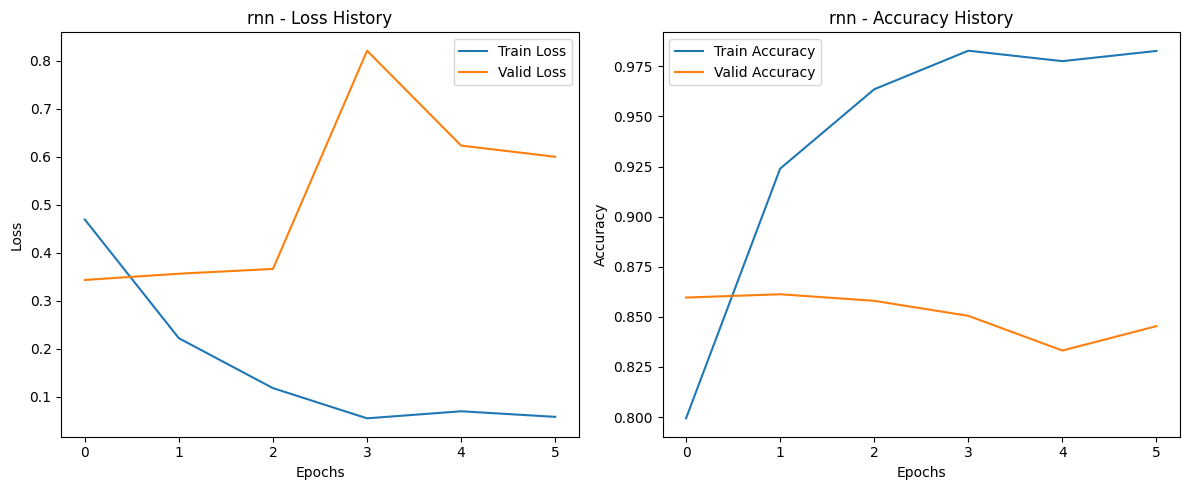

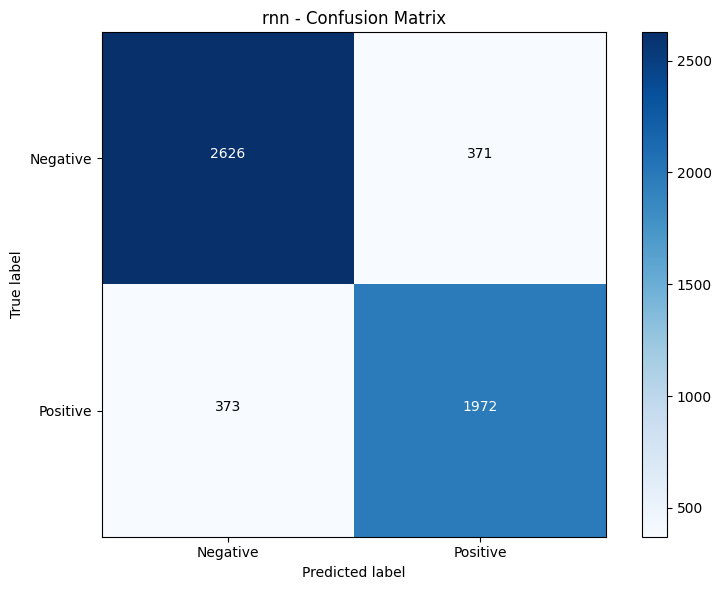

In [64]:
# Plotting hasil pelatihan
plot_training_history(history_rnn, "rnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_rnn['y_pred'], "rnn")

## 5. Menyimpan Model

In [65]:
# Menyimpan model
model_rnn.save('model_tensorflow_rnn.keras')
print("Model RNN disimpan sebagai 'model_rnn.keras'")

Model RNN disimpan sebagai 'model_rnn.keras'


# B. LSTM dengan Tensorflow

## 1. Menyusun Model LSTM


In [66]:
# Fungsi untuk membuat model LSTM kompleks
def build_lstm_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),

        LSTM(HIDDEN_DIM, return_sequences=True),
        LSTM(HIDDEN_DIM // 2, return_sequences=False),
        Dropout(DROPOUT_RATE),

        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_lstm = build_lstm_model()

## 2. Melatih Model

In [67]:
# Menyusun model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model LSTM
print("Melatih model LSTM...")
history_lstm = train_model(model_lstm, train_data, 'lstm')

Melatih model LSTM...
Memulai pelatihan model lstm...
Epoch 1/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.7794 - loss: 0.4525 - val_accuracy: 0.8765 - val_loss: 0.2944
Epoch 2/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9605 - loss: 0.1206 - val_accuracy: 0.8690 - val_loss: 0.3562
Epoch 3/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9838 - loss: 0.0584 - val_accuracy: 0.8566 - val_loss: 0.4218
Epoch 4/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9924 - loss: 0.0325 - val_accuracy: 0.8472 - val_loss: 0.5729
Epoch 5/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9964 - loss: 0.0143 - val_accuracy: 0.8460 - val_loss: 0.8474
Epoch 6/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9985 - loss: 0.0081 - val_accuracy: 0.8460 - val_loss: 0.7763
Waktu pelatihan: 1m 14s


## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [68]:
# Evaluasi model LSTM
result_lstm = evaluate_model(model_lstm, test_data, 'lstm')

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Evaluasi Model lstm:
Accuracy: 0.8823
Precision: 0.8698
Recall: 0.8606
F1 Score: 0.8652
AUC: 0.9484


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

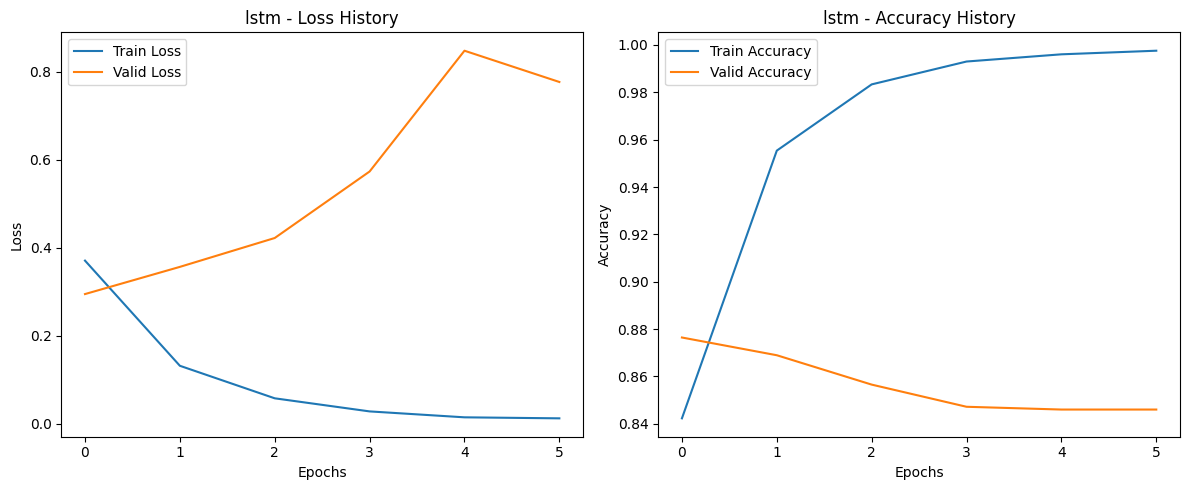

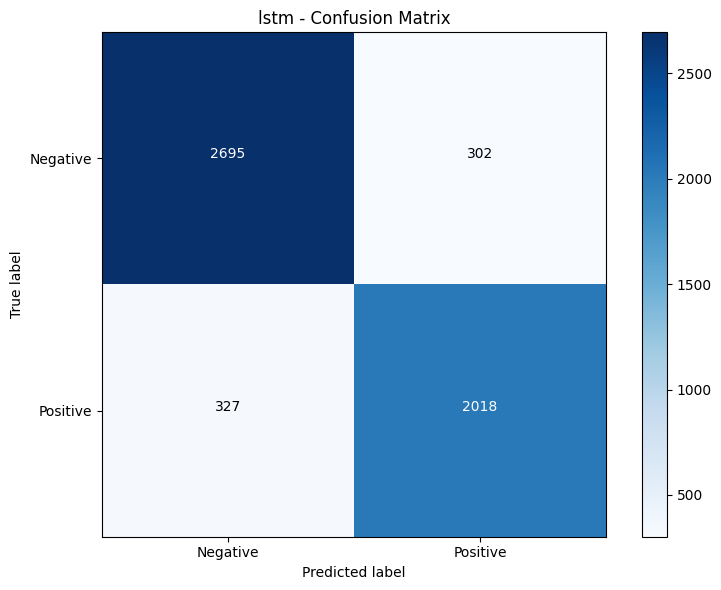

In [69]:
# Plotting hasil pelatihan
plot_training_history(history_lstm, "lstm")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_lstm['y_pred'], "lstm")

## 5. Menyimpan Model

In [70]:
# Menyimpan model
model_lstm.save('model_tensorflow_lstm.keras')
print("Model LSTM disimpan sebagai 'model_tensorflow_lstm.keras'")

Model LSTM disimpan sebagai 'model_tensorflow_lstm.keras'


# C. GRU dengan Tensorflow

## 1. Menyusun Model GRU


In [71]:
# Fungsi untuk membuat model GRU kompleks
def build_gru_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),
        
        GRU(HIDDEN_DIM, return_sequences=True),
        GRU(HIDDEN_DIM // 2, return_sequences=False),
        Dropout(DROPOUT_RATE),

        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_gru = build_gru_model()

## 2. Melatih Model

In [72]:
# Menyusun model
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model GRU
print("Melatih model gru...")
history_gru = train_model(model_gru, train_data, 'gru')

Melatih model gru...
Memulai pelatihan model gru...
Epoch 1/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.7147 - loss: 0.5237 - val_accuracy: 0.8823 - val_loss: 0.3005
Epoch 2/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9500 - loss: 0.1469 - val_accuracy: 0.8748 - val_loss: 0.3232
Epoch 3/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9881 - loss: 0.0465 - val_accuracy: 0.8673 - val_loss: 0.3930
Epoch 4/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9947 - loss: 0.0202 - val_accuracy: 0.8577 - val_loss: 0.4950
Epoch 5/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9969 - loss: 0.0128 - val_accuracy: 0.8437 - val_loss: 0.8752
Epoch 6/20
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9984 - loss: 0.0079 - val_accuracy: 0.8547 - val_loss: 0.7862
Waktu pelatihan: 1m 13s


## 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [73]:
# Evaluasi model GRU
print("Evaluasi model GRU...")
result_gru = evaluate_model(model_gru, test_data, 'gru')

Evaluasi model GRU...
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Evaluasi Model gru:
Accuracy: 0.8826
Precision: 0.8588
Recall: 0.8768
F1 Score: 0.8677
AUC: 0.9497


## 4. Memvisualisasikan Prediksi dari model yang telah dilatih

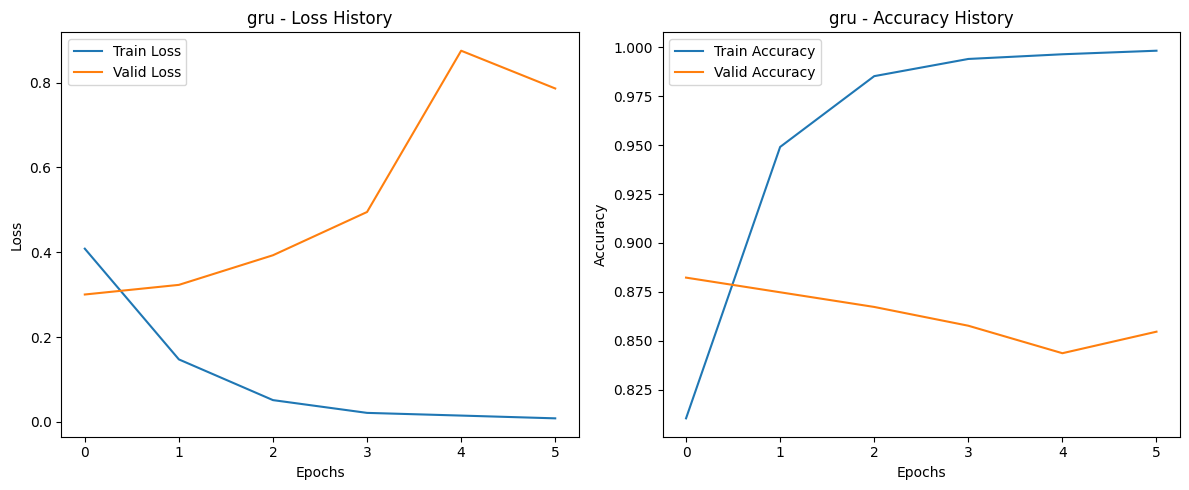

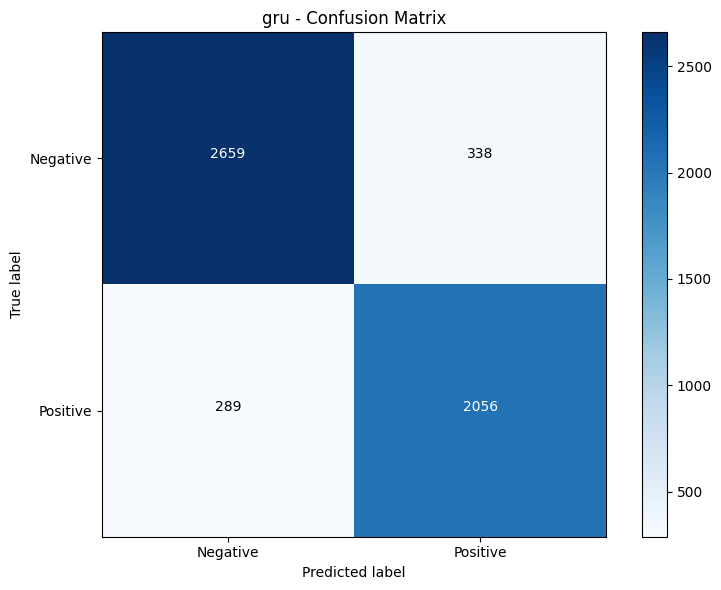

In [74]:
# Plotting hasil pelatihan
plot_training_history(history_gru, "gru")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_gru['y_pred'], "gru")

## 5. Menyimpan Model

In [75]:
# Menyimpan model
model_gru.save('model_tensorflow_gru.keras')
print("Model GRU disimpan sebagai 'model_tenosrflow_gru.keras'")

Model GRU disimpan sebagai 'model_tenosrflow_gru.keras'


# Perbandingan antara model

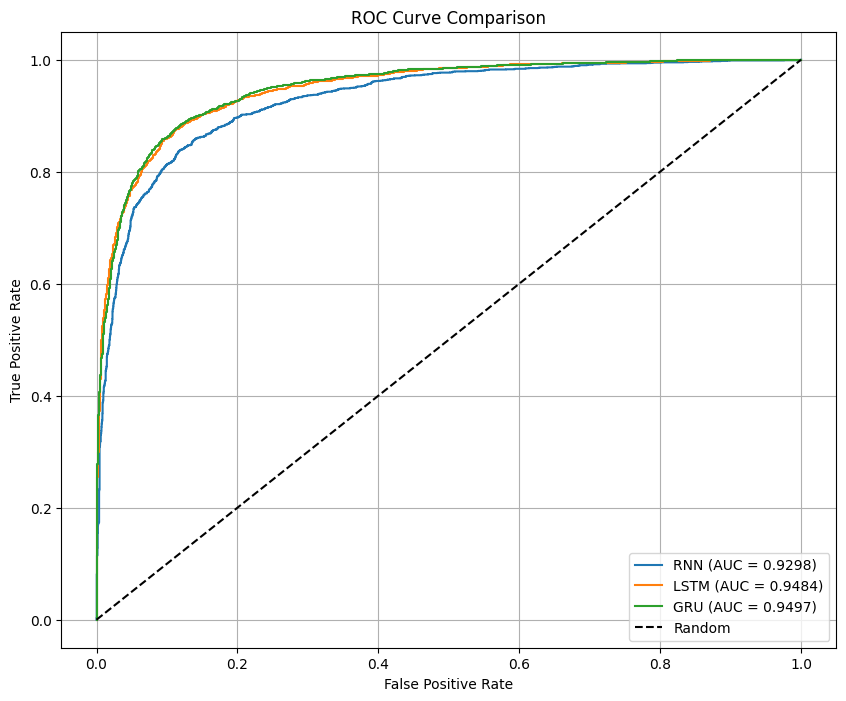

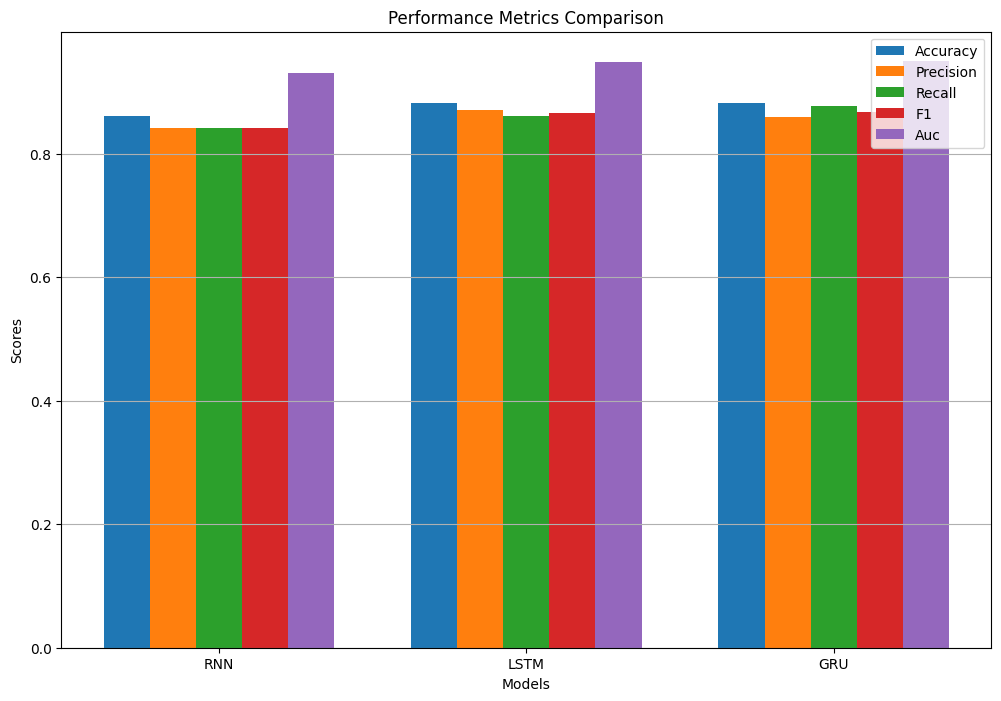

In [76]:
# Menghitung perbandingan untuk semua model
results_dict = {
    'RNN': result_rnn,
    'LSTM': result_lstm,
    'GRU': result_gru
}

# Plotting ROC curve
plot_roc_curve(results_dict)
# Plotting perbandingan metrik
plot_metrics_comparison(results_dict)